# Importing essential libs

In [1]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sb
import numpy as np
import re
import json

# Reddit authentication

### Subreddit definition

In [2]:
sub = "conservative"

### Get credentials

In [3]:
with open("credentials.json") as f:
    params = json.load(f)

### Initialization

In [4]:
reddit = praw.Reddit(client_id=params["client_id"],
                     client_secret=params["client_secret"],
                     user_agent="suicidalcrocodile's script")

# Dataset Creation

### Collect relevant data

In [5]:
allposts = list()
for post in reddit.subreddit(sub).hot(limit=1000):
  allposts.append([None if post.author is None else post.author.name, 
                   post.name, 
                   post.title, 
                   post.selftext, 
                   post.num_comments, 
                   post.score,
                   post.created_utc	])

### How many posts do we have in hand?

In [6]:
print("Post count: {0}".format(len(allposts)))

Post count: 959


### Initialize dataset with collected data

In [7]:
dataset = pd.DataFrame(allposts, columns=["Author", 
                                          "Name",
                                          "Title", 
                                          "Text", 
                                          "Num_Comments", 
                                          "Score",
                                          "CreatedUTC"])

### Correct dataset date of creation column

In [8]:
dataset['CreatedUTC'] = pd.to_datetime(dataset['CreatedUTC'],unit='s')

### Inspect head (first 10 rows)

In [9]:
dataset.head(15)

,Author,Name,Title,Text,Num_Comments,Score,CreatedUTC
0,Jibrish,t3_gdexcu,/r/Conservative Official Political Discord,In response to the [reddit chat fiasco..](http...,44,193,2020-05-04 16:37:26
1,thatrightwinger,t3_gjv9n0,Why ObamaGate is Such a Huge Scandal,,38,29,2020-05-14 21:16:01
2,HardRightJayBird,t3_gjnilv,Reason #51 why I’m leaving the Democratic Party,,506,3786,2020-05-14 14:35:19
3,Kevlar987,t3_gjmmhi,"CNN: Why is Trump giving medical advice, he’s ...",,94,1535,2020-05-14 13:44:59
4,Mike_Darbishire,t3_gjp3vi,​​American College Of Pediatrics Reaches Decis...,,58,933,2020-05-14 15:59:38
5,Jibrish,t3_gjkhgt,Don't you worry...,,293,2430,2020-05-14 11:23:17
6,NineteenEighty9,t3_gjthfw,How to solve all problems,,25,349,2020-05-14 19:43:53
7,russtj,t3_gjpo2j,Netflix's 'Jeffrey Epstein' Trailer Shows Trum...,,64,453,2020-05-14 16:29:02
8,optionhome,t3_gjsjim,CNN Buries Poll Showing Trump Crushing Biden I...,,25,247,2020-05-14 18:55:47
9,ngoni,t3_gjoiqv,It's Still Not Safe to Come Out,,18,397,2020-05-14 15:28:29


# Visualization

#### Extra step: using matplotlib widget

In [10]:
%matplotlib notebook

### Date distribution of dataset

<IPython.core.display.Javascript object>


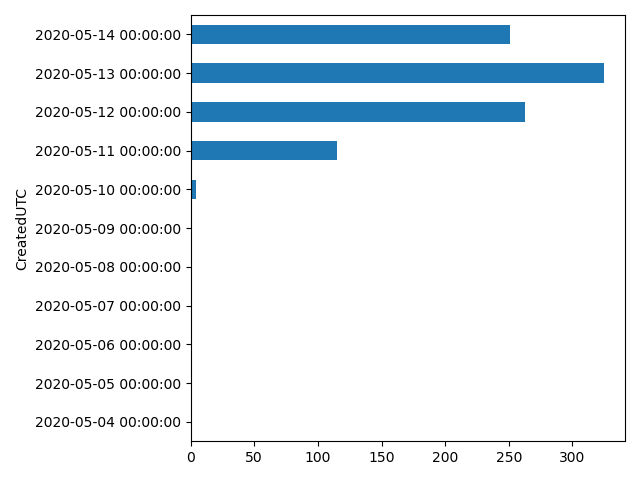

In [11]:
plt.figure()
dataset.groupby(pd.Grouper(key="CreatedUTC", freq="D")).size().plot(kind='barh', rot=0)
plt.tight_layout()

### Initialize a few useful variables

##### Get all titles

In [12]:
titles_values = dataset["Title"].values.astype("str")

#### Define a in-string word finder, see https://stackoverflow.com/a/52304664

In [13]:
def find_only_whole_word(search_string, input_string):
  # Create a raw string with word boundaries from the user's input_string
  raw_search_string = r"\b" + search_string + r"\b"

  match_output = re.search(raw_search_string, input_string)
  ##As noted by @OmPrakesh, if you want to ignore case, uncomment
  ##the next two lines
  #match_output = re.search(raw_search_string, input_string, 
  #                         flags=re.IGNORECASE)

  no_match_was_found = ( match_output is None )
  if no_match_was_found:
    return False
  else:
    return True

### Create bag-of-words model

#### Use sklearn's CountVectorizer to extract *titles* bag of words from dataset

In [14]:
cv = CountVectorizer(stop_words="english")
titles_bow = cv.fit_transform(dataset["Title"].values)

#### Sum words to get exact term count

In [15]:
sum_titles_words= titles_bow.sum(axis=0)
sum_map_titles_words = [(word, sum_titles_words[0, i]) for word, i in cv.vocabulary_.items()]
sum_map_titles_words = sorted(sum_map_titles_words, key = lambda x: x[1], reverse=True)

#### Import summed term counts and visualize

<IPython.core.display.Javascript object>


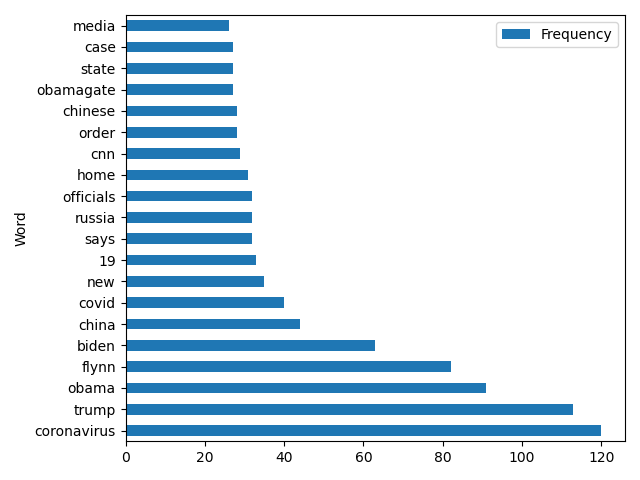

In [16]:
common_words_ds = pd.DataFrame(sum_map_titles_words[:20], columns=["Word", "Frequency"])
common_words_ds.plot.barh(x="Word", y="Frequency", rot=0)
plt.tight_layout()

#### Visualize wordcloud

<IPython.core.display.Javascript object>


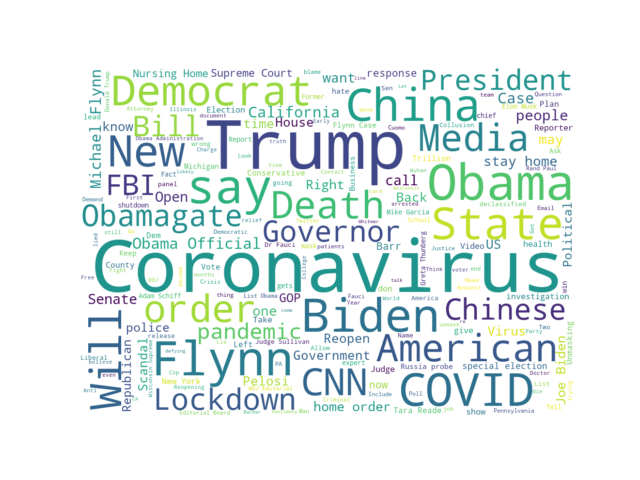

In [17]:
plt.figure() #if i dont do this, it renders on the plot above...
stopwords = set(STOPWORDS)
titles = dataset["Title"].values
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=720).generate(" ".join(titles))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualizing data on popular terms

#### Add popterm columns

To each row in the dataset I'm going to expose which popular terms they mention in the title, there are some implications however. If a post mentions more than one popular term in the title the primary popular term will be the most popular one of the two, that said, to allow the second one to manifest itself in the data I'll add more than one column to expose the popular terms so this second term would be the secondary popular term.
so as an example: in a dataset where the two most popular terms are "dog" and "pet", in that order, the phrase "I have a pet at home, it's a beautiful dog." the primary popular term would be "dog" and the secondary popular term would be "pet"

- Firstly, create the 3 popular term columns, separatedly, in popular terms dataset with indexes matching the initial dataset

In [18]:
most_frequent_terms = list(x[0] for x in sum_map_titles_words[:3])
popular_terms_colls = list()
for title in np.char.lower(titles_values):
  title_popular_terms = np.empty(len(most_frequent_terms),dtype=titles_values.dtype)
  pop_terms_count = 0
  for frequent_term in most_frequent_terms:
    if find_only_whole_word(frequent_term, title):
      title_popular_terms[pop_terms_count] = frequent_term
      pop_terms_count+=1
  popular_terms_colls.append(title_popular_terms)

popular_terms_ds = pd.DataFrame(popular_terms_colls, columns=["PopTerm{0}".format(str(i+1)) for i in range(len(most_frequent_terms))]).astype(str)

- Inspect head of popular terms dataset

In [19]:
popular_terms_ds.head(15)

,PopTerm1,PopTerm2,PopTerm3
0,,,
1,,,
2,,,
3,coronavirus,trump,
4,,,
5,,,
6,,,
7,trump,,
8,trump,,
9,,,


You can check the initial dataset's head to see if those indexes truly mention those terms

- There will be a lot of empty values in these columns since not all posts are about these 3 most popular terms, let's fix that:

In [20]:
popular_terms_ds.replace(r'^\s*$', np.nan, regex=True, inplace=True)

and run ``head()`` again:

In [21]:
popular_terms_ds.head(15)

,PopTerm1,PopTerm2,PopTerm3
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,coronavirus,trump,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,trump,NaN,NaN
8,trump,NaN,NaN
9,NaN,NaN,NaN


#### Create compiled dataset with initial and popular terms data

In [22]:
dataset_with_popterms=dataset.join(popular_terms_ds)
dataset_with_popterms.head(15)

,Author,Name,Title,Text,Num_Comments,Score,CreatedUTC,PopTerm1,PopTerm2,PopTerm3
0,Jibrish,t3_gdexcu,/r/Conservative Official Political Discord,In response to the [reddit chat fiasco..](http...,44,193,2020-05-04 16:37:26,NaN,NaN,NaN
1,thatrightwinger,t3_gjv9n0,Why ObamaGate is Such a Huge Scandal,,38,29,2020-05-14 21:16:01,NaN,NaN,NaN
2,HardRightJayBird,t3_gjnilv,Reason #51 why I’m leaving the Democratic Party,,506,3786,2020-05-14 14:35:19,NaN,NaN,NaN
3,Kevlar987,t3_gjmmhi,"CNN: Why is Trump giving medical advice, he’s ...",,94,1535,2020-05-14 13:44:59,coronavirus,trump,NaN
4,Mike_Darbishire,t3_gjp3vi,​​American College Of Pediatrics Reaches Decis...,,58,933,2020-05-14 15:59:38,NaN,NaN,NaN
5,Jibrish,t3_gjkhgt,Don't you worry...,,293,2430,2020-05-14 11:23:17,NaN,NaN,NaN
6,NineteenEighty9,t3_gjthfw,How to solve all problems,,25,349,2020-05-14 19:43:53,NaN,NaN,NaN
7,russtj,t3_gjpo2j,Netflix's 'Jeffrey Epstein' Trailer Shows Trum...,,64,453,2020-05-14 16:29:02,trump,NaN,NaN
8,optionhome,t3_gjsjim,CNN Buries Poll Showing Trump Crushing Biden I...,,25,247,2020-05-14 18:55:47,trump,NaN,NaN
9,ngoni,t3_gjoiqv,It's Still Not Safe to Come Out,,18,397,2020-05-14 15:28:29,NaN,NaN,NaN


#### PopTerm1 vs Score scatter plot

<IPython.core.display.Javascript object>


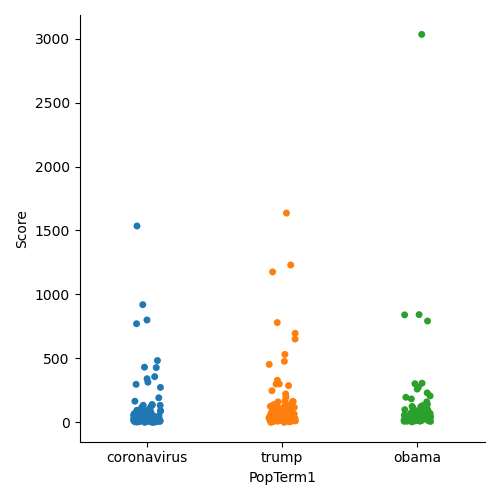

In [35]:
ax = sb.catplot(x="PopTerm1", y="Score", data=dataset_with_popterms);
#ax.set(yscale="log") #setting to log scale if necessary

#### PopTerm1 vs Mean Score bar plot

<IPython.core.display.Javascript object>


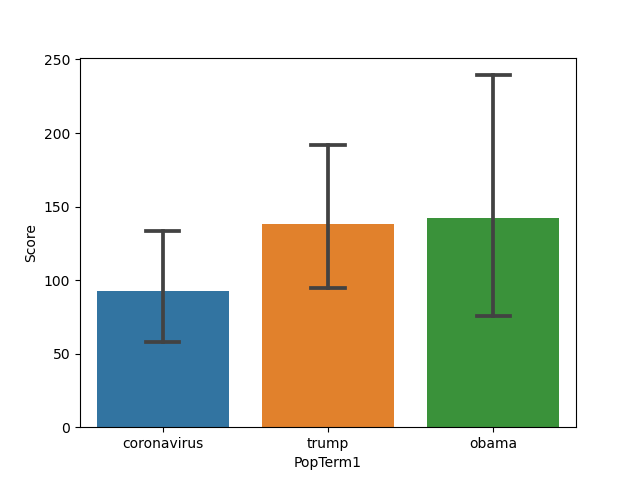

In [24]:
plt.figure() #if i dont do this, it renders on the plot above...
sb.barplot(x="PopTerm1", y="Score", data=dataset_with_popterms, capsize=.2)

#### PopTerm1 vs Score box plot (without outliers)

<IPython.core.display.Javascript object>


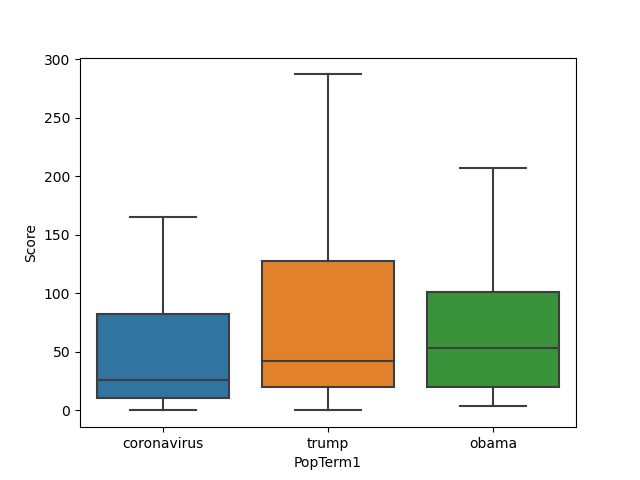

In [25]:
plt.figure() #if i dont do this, it renders on the plot above...
ax=sb.boxplot(x="PopTerm1", y="Score", data=dataset_with_popterms, showfliers=False)
#showFliers can be set to True to show outliers

#### PopTerm1 vs Mean Num_Comments bar plot

<IPython.core.display.Javascript object>


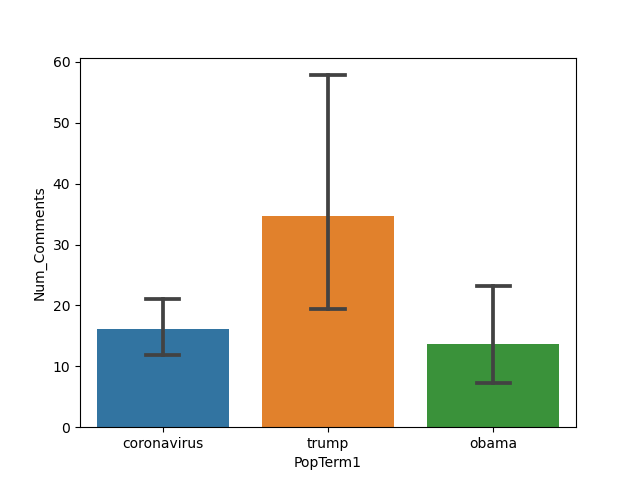

In [26]:
plt.figure() #if i dont do this, it renders on the plot above...
sb.barplot(x="PopTerm1", y="Num_Comments", data=dataset_with_popterms, capsize=.2)

#### PopTerm1 vs Num_Comments box plot

<IPython.core.display.Javascript object>


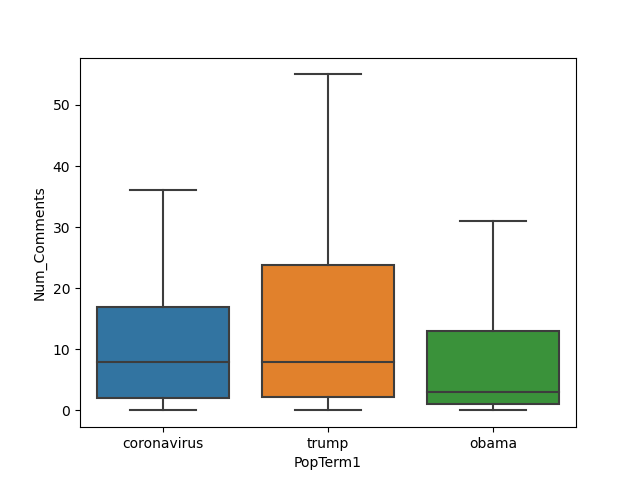

In [27]:
plt.figure() #if i dont do this, it renders on the plot above...
sb.boxplot(x="PopTerm1", y="Num_Comments", data=dataset_with_popterms, showfliers=False)

### Visualizing authors in relation to popular terms

Before proceeding, check how many UNIQUE authors we have in our dataset:

In [28]:
print("Unique authors:{0}".format(dataset_with_popterms["Author"].nunique()))

Unique authors:312


#### Plot 10 most frequent authors (in general)

<IPython.core.display.Javascript object>


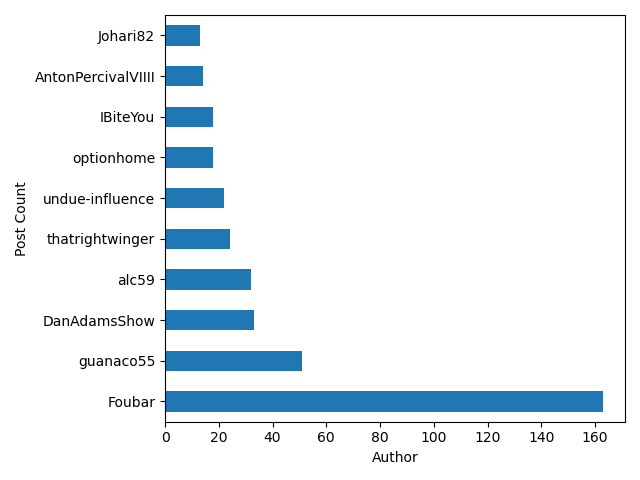

In [29]:
plt.figure() #if i dont do this, it renders on the plot above...
ax=dataset_with_popterms["Author"].value_counts(sort=True, normalize=False)[:10].plot(kind="barh", rot=0)
ax.set_ylabel("Post Count")
ax.set_xlabel("Author")
plt.tight_layout()

#### Plot 10 most frequent authors of popular terms

<IPython.core.display.Javascript object>


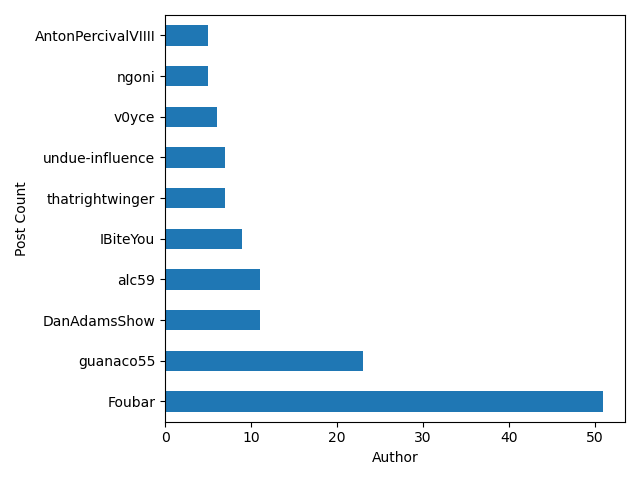

In [30]:
plt.figure() #if i dont do this, it renders on the plot above...
ax=dataset_with_popterms[dataset_with_popterms["PopTerm1"].notna()]["Author"].value_counts()[:10].plot(kind="barh", rot=0)
ax.set_ylabel("Post Count")
ax.set_xlabel("Author")
plt.tight_layout()

#### Plot the 10 most frequent authors of each popular term

<IPython.core.display.Javascript object>


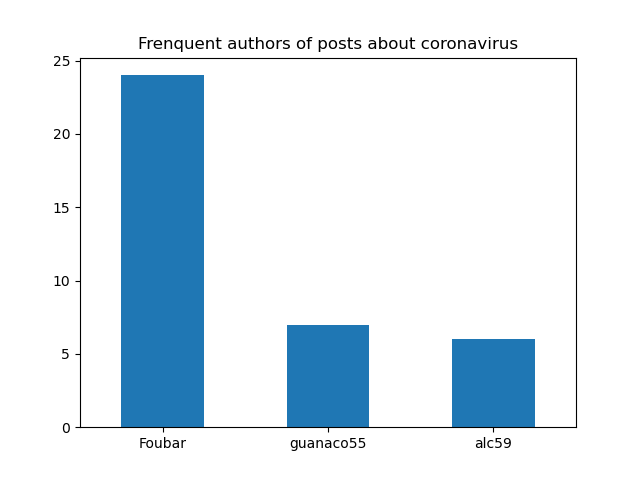

<IPython.core.display.Javascript object>


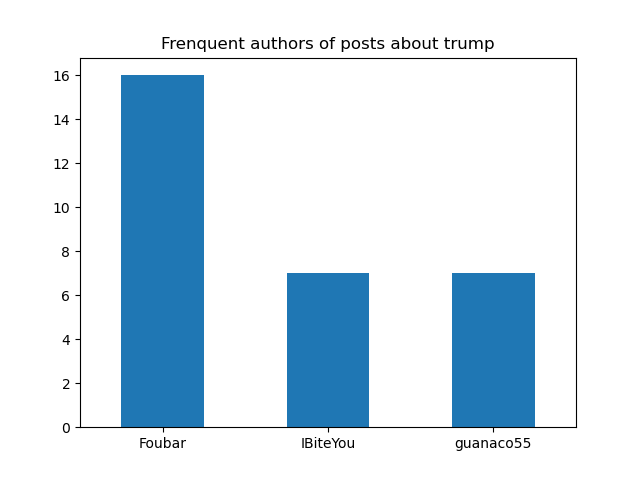

<IPython.core.display.Javascript object>


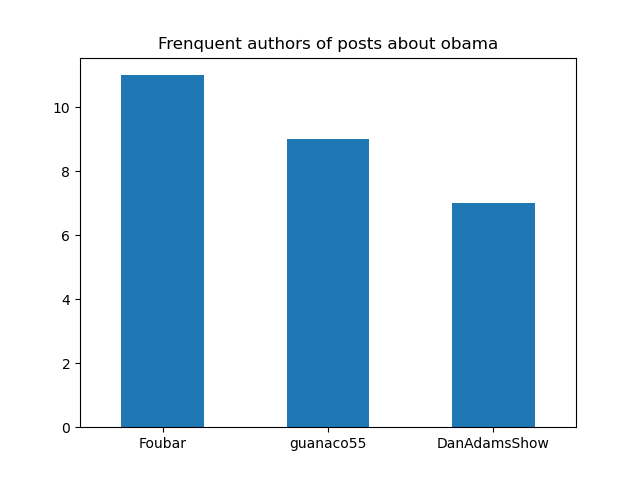

In [31]:
for pop_term in most_frequent_terms:
  plt.figure()
  dataset_with_popterms[dataset_with_popterms["PopTerm1"]==pop_term]["Author"].value_counts()[:3].plot(kind="bar",rot=0, title="Frenquent authors of posts about {0}".format(pop_term))

#### Plot the 10 most frequent authors vs Popular term post

<IPython.core.display.Javascript object>


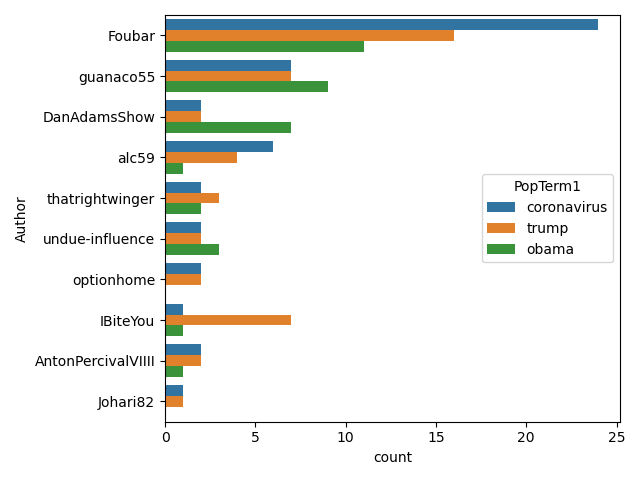

In [32]:
plt.figure() #if i dont do this, it renders on the plot above...
sb.countplot(y="Author", orient="h", data=dataset_with_popterms,order=dataset_with_popterms["Author"].value_counts().iloc[:10].index, hue="PopTerm1")
plt.tight_layout()

#### Authors vs Mean Score

<IPython.core.display.Javascript object>


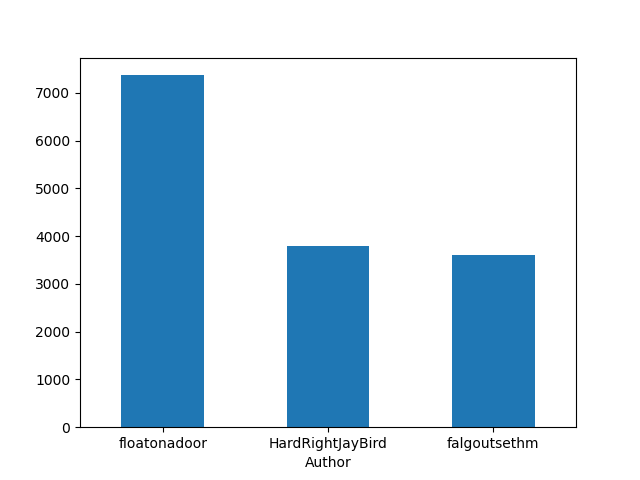

In [33]:
plt.figure() #if i dont do this, it renders on the plot above...
dataset_with_popterms.groupby("Author")["Score"].mean().sort_values(ascending=False)[:3].plot(kind="bar", rot=0)

#### Authors vs Mean Score among posts about popular terms

<IPython.core.display.Javascript object>


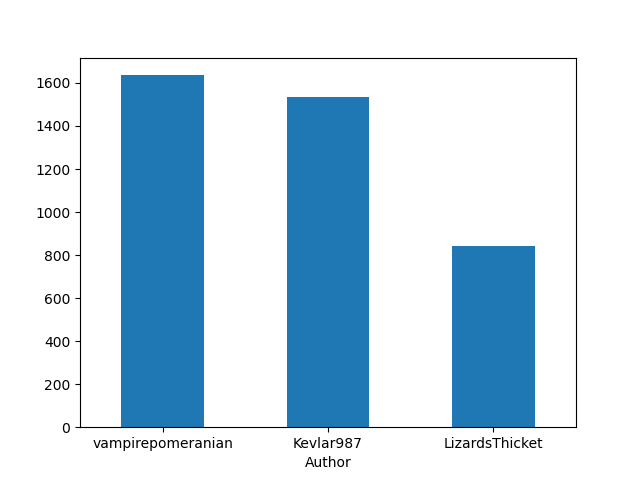

In [34]:
plt.figure() #if i dont do this, it renders on the plot above...
dataset_with_popterms[dataset_with_popterms["PopTerm1"].notna()].groupby("Author")["Score"].mean().sort_values(ascending=False)[:3].plot(kind="bar", rot=0)